In [5]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [6]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torch
from IPython.display import Image  # for displaying images
import os, glob 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [8]:
!wget https://www.dropbox.com/s/pyjdiq0vhdfgq8a/voc.zip
!unzip voc.zip

--2022-07-04 06:38:58--  https://www.dropbox.com/s/pyjdiq0vhdfgq8a/voc.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pyjdiq0vhdfgq8a/voc.zip [following]
--2022-07-04 06:38:58--  https://www.dropbox.com/s/raw/pyjdiq0vhdfgq8a/voc.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucedea0e6d7de23d90fa3853dd3c.dl.dropboxusercontent.com/cd/0/inline/BoYE_35oqFFoLwsYduG2lPZAisb_Q9KwnwheADqsdLYj0KC7yfaT2Z9mMeCHlwg4d0wRqJVM8JNd24TkWwzOREeXqulC94h_C9wTzJSO3-mkCXVjyVW1HvwuEsLovvWab0fNIZdrC6QDZEQUpIRZWVAYa7UOGtsBZT9KYL1-M8CP9g/file# [following]
--2022-07-04 06:38:59--  https://ucedea0e6d7de23d90fa3853dd3c.dl.dropboxusercontent.com/cd/0/inline/BoYE_35oqFFoLwsYduG2lPZAisb_Q9KwnwheADqsdLYj0KC7yfaT2Z9mMeCHlwg4d0wRqJVM8JNd24TkW

In [9]:
!cd ./voc07/

In [10]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append((subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = (subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict


In [11]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"ned_p_v": 0}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = int((float(b["xmin"]) + float(b["xmax"])) / 2 )
        b_center_y = int((float(b["ymin"]) + float(b["ymax"])) / 2)
        b_width    = int((float(b["xmax"]) - float(b["xmin"])))
        b_height   = int((float(b["ymax"]) - float(b["ymin"])))
        str
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= int(image_w) 
        b_center_y /= int(image_h) 
        b_width    /= int(image_w) 
        b_height   /= int(image_h) 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("/content/voc07/Annotations", info_dict["filename"].replace("xml", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [12]:
# Get the annotations
annotations = [os.path.join('/content/voc07/Annotations', x) for x in os.listdir('/content/voc07/Annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('/content/voc07/Annotations', x) for x in os.listdir('/content/voc07/Annotations') if x[-3:] == "txt"]

100%|██████████| 1883/1883 [00:01<00:00, 1790.34it/s]


In [13]:
os.chdir('/content/voc07/Annotations/')
for file in glob.glob('*.jpg'):
  file_name = file
  file_name_array=file_name.split('.')
  new_file_name = file_name_array[0]+'.txt'
  os.system('cp /content/voc07/Annotations/'+file_name+' /content/voc07/Annotations/'+new_file_name)

In [14]:
os.chdir('/content/voc07/Annotations/')
for file in glob.glob('*.jpg'):
  file_name = file
  os.system('rm /content/voc07/Annotations/'+file_name)

In [15]:
'''
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
os.chdir('/content/voc07/Annotations/')
for file in glob.glob('*.txt'): 
  file_name=file

  with open(file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[y for y in x ] for x in annotation_list]

  os.system('cp /content/voc07/Annotations/'+file_name+' /content/voc07/images/'+new_file_name)

#Get the corresponding image file
image_file = annotation_file.replace("/content/voc07/Annotations/", "/content/voc07/images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)
'''

'\nrandom.seed(0)\n\nclass_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))\n\ndef plot_bounding_box(image, annotation_list):\n    annotations = np.array(annotation_list)\n    w, h = image.size\n    \n    plotted_image = ImageDraw.Draw(image)\n\n    transformed_annotations = np.copy(annotations)\n    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w\n    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h \n    \n    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)\n    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)\n    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]\n    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]\n    \n    for ann in transformed_annotations:\n        obj_cls, x0, y0, x1, y1 = ann\n        plotted_image.rectangle((

In [16]:
# Read images and annotations
images = [os.path.join('/content/voc07/JPEGImages', x) for x in os.listdir('/content/voc07/JPEGImages')]
annotations = [os.path.join('/content/voc07/Annotations/', x) for x in os.listdir('/content/voc07/Annotations/') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [17]:
!mkdir /content/voc07/JPEGImages/train /content/voc07/JPEGImages/val /content/voc07/JPEGImages/test /content/voc07/Annotations/train /content/voc07/Annotations/val /content/voc07/Annotations/test

In [18]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/voc07/JPEGImages/train')
move_files_to_folder(val_images, '/content/voc07/JPEGImages/val/')
move_files_to_folder(test_images, '/content/voc07/JPEGImages/test/')
move_files_to_folder(train_annotations, '/content/voc07/Annotations/train/')
move_files_to_folder(val_annotations, '/content/voc07/Annotations/val/')
move_files_to_folder(test_annotations, '/content/voc07/Annotations/test/')

In [19]:
!mv /content/voc07/Annotations /content/labels
!mv /content/voc07/JPEGImages/ /content/images
!cd /content/yolov5 

In [ ]:
!python /content/yolov5/train.py --img 1024 --cfg yolov5s.yaml --hyp /content/yolov5/data/hyps/hyp.Objects365.yaml --batch 32 --epochs 300 --data polygons_data.yaml --weights yolov5x.pt --workers 128 --name yolo_polygon_det

train: weights=yolov5x.pt, cfg=yolov5s.yaml, data=polygons_data.yaml, hyp=/content/yolov5/data/hyps/hyp.Objects365.yaml, epochs=300, batch_size=32, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=128, project=../yolov5/runs/train, name=yolo_polygon_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-275-g29d79a6 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.00258, lrf=0.17, momentum=0.779, weight_decay=0.00058, warmup_epochs=1.33, warmup_momentum=0.86, warmup_bias_lr=0.0711, box=0.0539, cls=0.299, cls_pw=0.825, obj=0.632, obj_pw=1.0, iou_

In [ ]:
!python /content/yolov5/detect.py --source /content/images/test/ --weights /content/yolov5/runs/train/yolo_polygon_det/weights/best.pt --conf 0.25 --name yolo_polygon_det

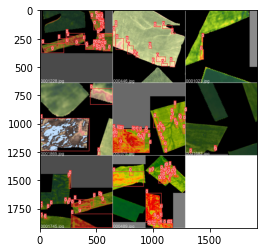

In [ ]:
detections_dir = "/content/yolov5/runs/train/yolo_polygon_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [20]:
!python /content/yolov5/val.py --weights /content/yolov5/runs/train/yolo_polygon_det/weights/best.pt --data polygons_data.yaml --task test --name yolo_polygon_det

val: data=/content/yolov5/data/polygons_data.yaml, weights=['yolov5s.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=../yolov5/runs/val, name=yolo_polygon_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-275-g29d79a6 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

100% 14.1M/14.1M [00:00<00:00, 141MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 18.0MB/s]
Traceback (most recent call last):
  File "/content/yolov5/val.py", line 394, in <module>
    main(opt)
  File "/content/yolov5/val.py", line 367, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/val.py", line 167, in run
    assert ncm =